<a href="https://colab.research.google.com/github/wassersteinball/example/blob/main/Wasserstein_Ball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.insert(0,'/content/example')

# *** EXAMPLE STARTS HERE ***

In [ ]:
from SIR_CEV_Model import SIR_CEV_Model
from PortfolioOptim import PortfolioOptim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import copy

# A sample market model

$\newcommand{\Con}{{\textrm{C}_{\pi| \delta}}}$
$\newcommand{\Coninv}{ \;\breve{{\!\!\textrm{C}}}_{\pi| \delta} }$
This market has a two risky assets and a bond

In [ ]:
# market model parameters
S0 = np.array([1, 2])
x0 = 1
pi = np.array([0.2, 0.6, 0.1])
T = 5

SIR_CEV_params = { "P" : { "mu" : np.array([0.05,0.06]),
                          "sigma" : np.array([0.2,0.32]),
                          "beta" : np.array([-0.2, -0.3]),
                          "rho" : np.array([[1, 0.25, 0.2],[0.25, 1, 0.3], [0.2, 0.3, 1] ]),
                          "r0" : 0.02,
                          "kappa" : 1,
                          "theta_r" : 0.02,
                          "sigma_r" : 0.02},
                  "Q" : { "kappa" : 1,
                          "theta_r" : 0.025,
                          "sigma_r" : 0.02}
    }

# generate the market model object
model = SIR_CEV_Model(x0, S0, pi, T, SIR_CEV_params)

In [ ]:
seed = 2^17-1

## Helper Functions for Grid generation and Plotting

In [ ]:
# some helper functions for generating the grid over which to integrate
def Create_a_b_grid(a, b, N):
    
    eps=0.002    
    
    u_eps = 10**(np.linspace(-10, np.log(eps)/np.log(10),10))-1e-11
    u_eps_flip = np.flip(copy.deepcopy(u_eps)) 

    u1 = a + u_eps
    u2 = np.linspace(a + eps, b - eps, N)
    u3 = b - u_eps_flip
    
    return np.concatenate((u1,u2, u3))


def Create_u_grid(pts):
     
    eps = 1e-6

    knots = np.sort(pts)

    u = Create_a_b_grid(eps, knots[0], 50)
    for i in range(1,len(knots)):
        u = np.concatenate((u, Create_a_b_grid(knots[i-1], knots[i], 200)))

    u = np.concatenate((u,Create_a_b_grid(knots[-1], 1-eps, 50) ))
    
    return u


def integrate(f, u):
    
    return np.sum(0.5*(f[:-1]+f[1:])*np.diff(u))

# a function for generating scatter plots of U, \tilde{U}, and V
def Plot_Uniforms(U, Ut, V, title="", n_samples = 5_000, figname=""):
    
    plt.figure(figsize=(10,10/3))

    plt.subplot(1,3,1)
    plt.scatter(U[:n_samples], Ut[:n_samples], s=0.2)
    plt.xlabel(r'$U^\delta$',fontsize=16)
    plt.ylabel(r'$\tilde{U}$',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.subplot(1,3,2)
    plt.scatter(U[:n_samples], V[:n_samples], s=0.2)
    plt.xlabel(r'$U^\delta$',fontsize=16)
    plt.ylabel(r'$V$',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)    

    plt.subplot(1,3,3)
    plt.scatter(Ut[:n_samples], V[:n_samples],  s=0.2)
    plt.ylabel(r'$V$',fontsize=16)
    plt.xlabel(r'$\tilde{U}$',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)    
    
    if not ( title == ""):
        plt.suptitle(title, fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
    else:
        plt.tight_layout()

    if not(figname == ""):
        plt.savefig(figname)
        
    plt.show()    
    
# for generating scatter plots and histogram of optimal termina wealth
from scipy import interpolate
from scipy.stats import norm

def GenerateOptScatterHist(PortOpt, X_delta, V, title, filename=""):

    g = interpolate.interp1d(PortOpt.u,PortOpt.gs)
    
    idx = (V>= PortOpt.u[0] ) *(V <= PortOpt.u[-1] )

    X_pi = g(V[idx])

    fig = plt.figure(figsize=(9,4))

    plt.subplot(1,2,1)
    plt.scatter(X_delta[idx], X_pi, s=0.5,alpha=0.2)
    plt.plot([0,3],[0,3],'--r')
    plt.ylim(0.25,3)
    plt.xlim(0.25,3)
    plt.xlabel(r"$X_T^\delta$",fontsize=16)
    plt.ylabel(r"$X_T^{\pi^*}$",fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.subplot(1,2,2)
    
    bins = np.linspace(0,3,100)
    
    h = 1.06*np.std(X_delta)*(len(X_delta))**(-1/5)
    f = lambda x, X, h : np.sum(  norm.pdf((x.reshape(1,-1)-X.reshape(-1,1))/h)/h, axis=0 ) / len(X)  
    
#     plt.hist(X_delta, bins=bins,density=True, alpha=0.25, label=r"$X_T^{\delta}$")
    plt.hist(X_pi, bins=np.linspace(0,3,100),density=True, label=r"$X_T^{\pi^*}$", color='#1f77b4')
    plt.plot(bins, f(bins, X_delta, h),  color='k', label=r"$X_T^{\delta}$")
    
    plt.xlabel(r"$x$",fontsize=16)
    plt.ylabel(r"$f_{X}(x)$",fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.show()

    if not filename == "":
        fig.savefig(filename)


# Risk-Measure



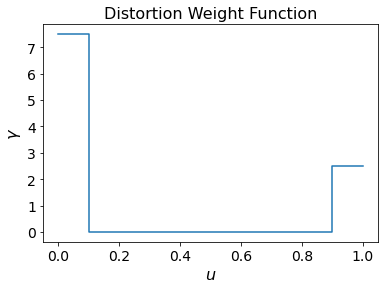

In [ ]:
# the risk-measures
alpha = 0.1
beta = 0.9
p_gamma = 0.75

# the CoIn copula parameter
us = 0.25

# The Wasserstein ball
epsilon = 0.1

# create a u-grid
u = Create_u_grid([alpha, beta, us])

# compute gamma along the grid
gamma = ( p_gamma*(u <= alpha) + (1-p_gamma)*(u >= beta) ) /(p_gamma*alpha+(1-p_gamma)*(1-beta))
gamma /= integrate( gamma, u)

# plot gamma
plt.plot(u,gamma)
plt.xlabel(r"$u$", fontsize=16)
plt.ylabel(r"$\gamma$", fontsize=16)
plt.title('Distortion Weight Function', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# CoIn Copula

compute simulations of SIR-CEV model and $V$ random variable under the CoIn Copula

Below, we show how the variable names correpsonding to the formulae in the paper: 
$$
\begin{align}
    X &:= X_T^\delta  \\
    Z &:= \varsigma_T \\
    \text{U_X} &:= U^\delta = F_{X_T^\delta}(X_T^\delta) \\
    \text{U_Z} &:= F_{\varsigma_T}(\varsigma_T) \\
    \text{U_Z_X} &:= \tilde{U}  = F_{\varsigma_T | X_T^\delta}(\varsigma_T | X_T^\delta) \\
    V &:= \;\breve{{\!\!\textrm{C}}}_{\pi| \delta}\Big(1 - F_{\varsigma_T\,|\,U^\delta}\left(\varsigma_T\;|\; U^\delta\right)\, \Big|\,  U^\delta\Big) \\
    \text{f_V_eval} &:= f_{V}^{\mathbb{P}}(v) \\
    \text{f_V_Q_eval} &:= f_{V}^{\mathbb{Q}}(v),
\end{align}
$$
where $v$ is a grid of points on which f_V_eval and f_V_Q_eval are computed on

In [ ]:
# simulate the market
np.random.seed(seed)  # randomize seed

Ndt = T*100
Nsims = 10_000
u_grid = u
measure ="P"
copula = "CoIn"

X, Z, U_X, U_Z, U_Z_X, V, v, f_V_eval, f_V_Q_eval = model.Sim_Uniforms_Xi({"us":us}, Ndt, Nsims, u_grid, measure, copula)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

CoIn


<IPython.core.display.Math object>

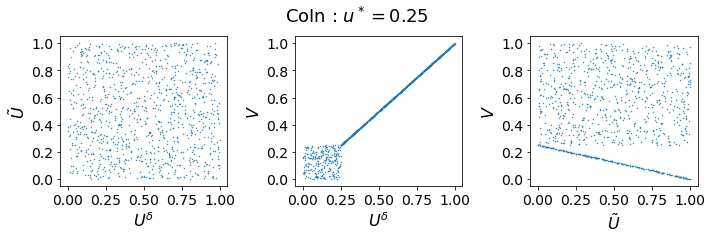

In [ ]:
# show scatter plot of simulated uniforms

title="CoIn : $u^*={0:0.2f}$".format(us)
Plot_Uniforms(U_X, U_Z_X, V, title=title, n_samples = 1_000)

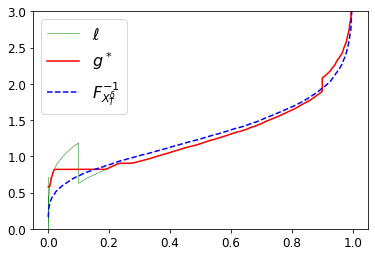

lambda = 6.763, 1.044
Wasserstein Distance = 0.100
Budget = 1.000
Risk measure = -1.195


In [ ]:
# obtain optimal quantile function
PortOpt= PortfolioOptim(model, epsilon, gamma)

lambda_opt, WD, budget, RM, fig = PortOpt.Optimise()

fig.suptitle(r"$p={0:0.2f}$".format(p_gamma), fontsize=16)

print('lambda = {0:0.3f}, {1:0.3f}'.format(lambda_opt[0],lambda_opt[1]))
print('Wasserstein Distance = {0:0.3f}'.format(WD))
print('Budget = {0:0.3f}'.format(budget))
print('Risk measure = {0:0.3f}'.format(RM))

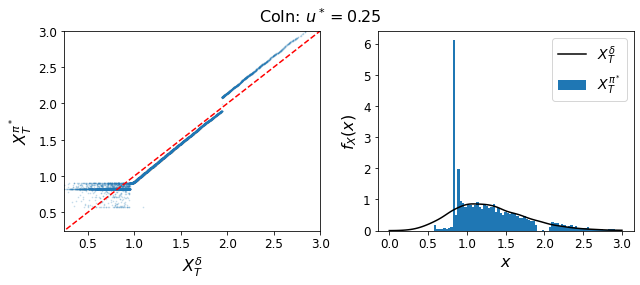

In [ ]:
# generate scatter plot of optimal strategy versus benchmark
GenerateOptScatterHist(PortOpt, X, V, r"CoIn: $u^*={0:0.2f}$".format(us))

# Gumbel Copula

compute simulations of SIR-CEV model and $V$ under the Gumbel copula. 

Below, we show how the variable names correpsonding to the formulae in the paper: 
$$
\begin{align}
    X &:= X_T^\delta  \\
    Z &:= \varsigma_T \\
    \text{U_X} &:= U^\delta = F_{X_T^\delta}(X_T^\delta) \\
    \text{U_Z} &:= F_{\varsigma_T}(\varsigma_T) \\
    \text{U_Z_X} &:= \tilde{U}  = F_{\varsigma_T | X_T^\delta}(\varsigma_T | X_T^\delta) \\
    V &:= \;\breve{{\!\!\textrm{C}}}_{\pi| \delta}\Big(1 - F_{\varsigma_T\,|\,U^\delta}\left(\varsigma_T\;|\; U^\delta\right)\, \Big|\,  U^\delta\Big) \\
    \text{f_V_eval} &:= f_{V}^{\mathbb{P}}(v) \\
    \text{f_V_Q_eval} &:= f_{V}^{\mathbb{Q}}(v),
\end{align}
$$
where $v$ is a grid of points on which f_V_eval and f_V_Q_eval are computed on

In [ ]:
# perform simulation
zeta = 4

np.random.seed(seed)

copula = "Gumbel"

X, Z, U_X, U_Z, U_Z_X, V, v, f_V_eval, f_V_Q_eval = model.Sim_Uniforms_Xi({"zeta":zeta}, Ndt, Nsims, u_grid, measure, copula)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Gumbel


<IPython.core.display.Math object>

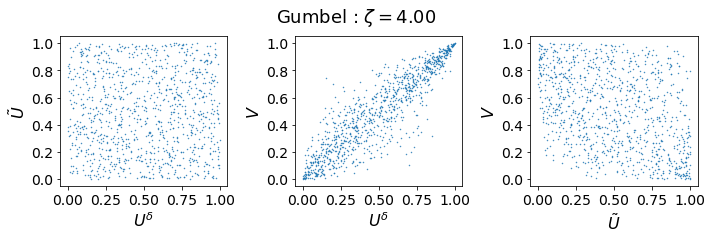

In [ ]:
title="Gumbel : $\zeta={0:0.2f}$".format(zeta)
Plot_Uniforms(U_X, U_Z_X, V, title=title, n_samples = 1_000)

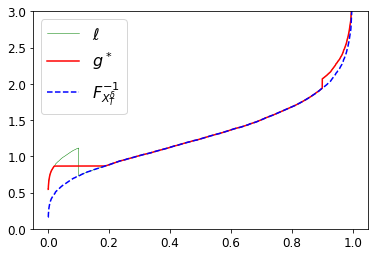

lambda = 9.725, 0.000
Wasserstein Distance = 0.100
Budget = 0.981
Risk measure = -1.231


In [ ]:
# perform the isotonic regression and enforce contraints
PortOpt= PortfolioOptim(model, epsilon, gamma)

lambda_opt, WD, budget, RM, fig = PortOpt.Optimise()

fig.suptitle(r"$p={0:0.2f}$".format(p_gamma), fontsize=16)
print('lambda = {0:0.3f}, {1:0.3f}'.format(lambda_opt[0],lambda_opt[1]))
print('Wasserstein Distance = {0:0.3f}'.format(WD))
print('Budget = {0:0.3f}'.format(budget))
print('Risk measure = {0:0.3f}'.format(RM))

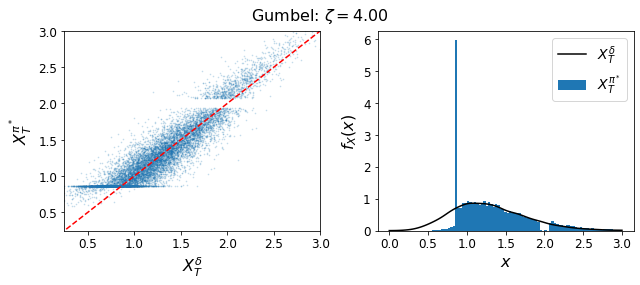

In [ ]:
GenerateOptScatterHist(PortOpt, X, V, r"Gumbel: $\zeta={0:0.2f}$".format(zeta))

# All Copula

Compute simulations of SIR-CEV model, and $V$ when no copula is specified, i.e., search over all copula. 

Below, we show how the variable names correpsonding to the formulae in the paper: 
$$
\begin{align}
    X &:= X_T^\delta  \\
    Z &:= \varsigma_T \\
    \text{U_X} &:= U^\delta = F_{X_T^\delta}(X_T^\delta) \\
    \text{U_Z} &:= F_{\varsigma_T}(\varsigma_T) \\
    V &:= 1 - F_{\varsigma_T}\left(\varsigma_T\right) \\
    \text{f_V_eval} &:= f_{V}^{\mathbb{P}}(v) \\
    \text{f_V_Q_eval} &:= f_{V}^{\mathbb{Q}}(v),
\end{align}
$$
where $v$ is a grid of points on which f_V_eval and f_V_Q_eval are computed on

In [ ]:
np.random.seed(seed)

copula = "All"

X, Z, U_X, U_Z, _, V, v, f_V_eval, f_V_Q_eval = model.Sim_Uniforms_Xi([], Ndt, Nsims, u_grid, measure, copula)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

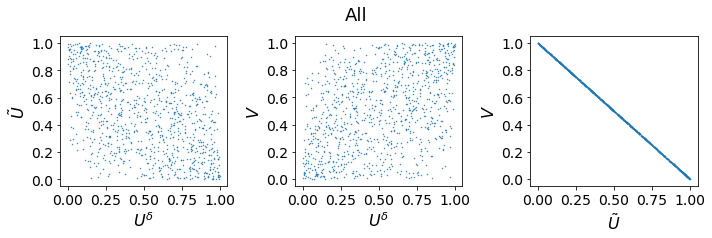

Here \tilde{U} := U_Z := F_{\varsigma_T}(\varsigma_T)


In [ ]:
title="All"
Plot_Uniforms(U_X, U_Z, V, title=title, n_samples = 1_000)
print(r"Here \tilde{U} := U_Z := F_{\varsigma_T}(\varsigma_T)")

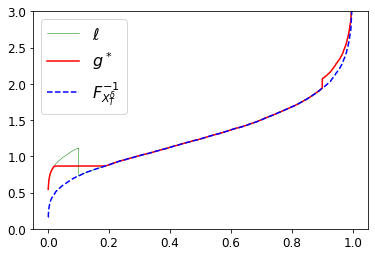

lambda = 9.725, 0.000
Wasserstein Distance = 0.100
Budget = 0.923
Risk measure = -1.231


In [ ]:
# find optimal quantile function
PortOpt= PortfolioOptim(model, epsilon, gamma)

lambda_opt, WD, budget, RM, fig = PortOpt.Optimise()

fig.suptitle(r"$p={0:0.2f}$".format(p_gamma), fontsize=16)

print('lambda = {0:0.3f}, {1:0.3f}'.format(lambda_opt[0],lambda_opt[1]))
print('Wasserstein Distance = {0:0.3f}'.format(WD))
print('Budget = {0:0.3f}'.format(budget))
print('Risk measure = {0:0.3f}'.format(RM))

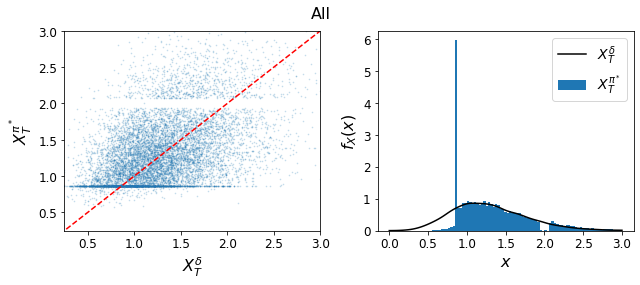

In [ ]:
GenerateOptScatterHist(PortOpt, X, V, r"All")